In [10]:
import time
import logging
from functools import wraps
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow
import mlflow.sklearn
import os

In [11]:
# Configuración básica de logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [12]:
def timer_decorator(func):
    """Decorador para medir el tiempo de ejecución de una función."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        logger.info(f"Función {func.__name__} ejecutada en {end_time - start_time:.2f} segundos")
        return result
    return wrapper


def log_decorator(func):
    """Decorador para registrar la entrada y salida de una función."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        logger.info(f"Llamando a la función: {func.__name__}")
        result = func(*args, **kwargs)
        logger.info(f"Función {func.__name__} completada")
        return result
    return wrapper


def error_handler(func):
    """Decorador para manejar y registrar errores."""
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            logger.error(f"Error en la función {func.__name__}: {str(e)}")
            raise
    return wrapper

In [13]:
# Ejemplo de uso:
@timer_decorator
@log_decorator
@error_handler
def example_function(x, y):
    """Una función de ejemplo para demostrar los decoradores."""
    logger.info(f"Operando con {x} y {y}")
    result = x / y
    return result

In [14]:
# Uso de la función de ejemplo:
try:
    result = example_function(10, 2)
    print(f"Resultado: {result}")
    result = example_function(10, 0)  # Esto generará un error
except Exception as e:
    print(f"Se capturó una excepción: {e}")

2024-10-25 17:12:31,883 - __main__ - INFO - Llamando a la función: example_function
2024-10-25 17:12:31,884 - __main__ - INFO - Operando con 10 y 2
2024-10-25 17:12:31,884 - __main__ - INFO - Función example_function completada
2024-10-25 17:12:31,884 - __main__ - INFO - Función example_function ejecutada en 0.00 segundos
2024-10-25 17:12:31,885 - __main__ - INFO - Llamando a la función: example_function
2024-10-25 17:12:31,885 - __main__ - INFO - Operando con 10 y 0
2024-10-25 17:12:31,885 - __main__ - ERROR - Error en la función example_function: division by zero


Resultado: 5.0
Se capturó una excepción: division by zero


In [15]:
class BankData:
    def __init__(self, file_path):
        self.file_path = file_path
        self.data = None

    @timer_decorator
    @error_handler
    @log_decorator
    def load_data(self):
        """Carga los datos del archivo CSV."""
        try:
            self.data = pd.read_csv(self.file_path)
            print(f"Datos cargados exitosamente. Shape: {self.data.shape}")
        except Exception as e:
            print(f"Error al cargar los datos: {e}")

    @timer_decorator
    @error_handler
    @log_decorator
    def get_info(self):
        """Obtiene información básica del dataset."""
        if self.data is not None:
            print(self.data.info())
        else:
            print("Los datos no han sido cargados aún.")

    @timer_decorator
    @error_handler
    @log_decorator
    def check_nulls(self):
        """Verifica y muestra la cantidad de valores nulos por columna."""
        if self.data is not None:
            null_counts = self.data.isnull().sum()
            print("Conteo de valores nulos por columna:")
            print(null_counts)
        else:
            print("Los datos no han sido cargados aún.")

    @timer_decorator
    @error_handler
    @log_decorator
    def handle_nulls(self, strategy='drop'):
        """
        Maneja los valores nulos en el dataset.

        :param strategy: Estrategia para manejar nulos ('drop' o 'impute')
        """
        if self.data is not None:
            if strategy == 'drop':
                self.data.dropna(inplace=True)
                print("Filas con valores nulos eliminadas.")
            elif strategy == 'impute':
                for column in self.data.columns:
                    if self.data[column].dtype == 'object':
                        self.data[column].fillna(self.data[column].mode()[0], inplace=True)
                    else:
                        self.data[column].fillna(self.data[column].mean(), inplace=True)
                print("Valores nulos imputados.")
            else:
                print("Estrategia no reconocida. Use 'drop' o 'impute'.")
        else:
            print("Los datos no han sido cargados aún.")

In [16]:
# Ejemplo de uso:
bank_data = BankData("../data/raw_data/creditcard.csv")

In [17]:
bank_data.load_data()

2024-10-25 17:12:38,644 - __main__ - INFO - Llamando a la función: load_data
2024-10-25 17:12:39,887 - __main__ - INFO - Función load_data completada
2024-10-25 17:12:39,888 - __main__ - INFO - Función load_data ejecutada en 1.24 segundos


Datos cargados exitosamente. Shape: (284807, 31)


In [18]:
bank_data.get_info()

2024-10-25 17:12:41,621 - __main__ - INFO - Llamando a la función: get_info
2024-10-25 17:12:41,642 - __main__ - INFO - Función get_info completada
2024-10-25 17:12:41,642 - __main__ - INFO - Función get_info ejecutada en 0.02 segundos


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [19]:
bank_data.check_nulls()

2024-10-25 17:12:43,079 - __main__ - INFO - Llamando a la función: check_nulls
2024-10-25 17:12:43,088 - __main__ - INFO - Función check_nulls completada
2024-10-25 17:12:43,096 - __main__ - INFO - Función check_nulls ejecutada en 0.02 segundos


Conteo de valores nulos por columna:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


In [20]:
# Vemos el dataset original
bank_data.data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

class DataPreparation:
    def __init__(self, data):
        self.data = data.copy()
        self.numeric_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 
                                'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 
                                'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']
        self.target_column = 'Class'

    @timer_decorator
    @error_handler
    @log_decorator
    def remove_irrelevant_columns(self):
        """Elimina columnas que no son relevantes para el análisis si existen."""
        columns_to_drop = ['Time']  # 'Time' no es relevante para este análisis
        existing_columns = [col for col in columns_to_drop if col in self.data.columns]
        if existing_columns:
            self.data.drop(columns=existing_columns, inplace=True)
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def handle_missing_values(self):
        """Maneja los valores faltantes en el conjunto de datos."""
        num_imputer = SimpleImputer(strategy='mean')
        self.data[self.numeric_columns] = num_imputer.fit_transform(self.data[self.numeric_columns])
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def normalize_numeric_features(self):
        """Normaliza las características numéricas."""
        scaler = StandardScaler()
        self.data[self.numeric_columns] = scaler.fit_transform(self.data[self.numeric_columns])
        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def balance_data_with_smote(self, test_size=0.3, random_state=42):
        """
        Balancea los datos utilizando SMOTE y divide en entrenamiento y prueba.

        :param test_size: Proporción de datos para el conjunto de prueba.
        :param random_state: Semilla para la reproducibilidad.
        """
        # Separar características y etiqueta
        X = self.data[self.numeric_columns]
        y = self.data[self.target_column]

        # Dividir el conjunto de datos en entrenamiento y prueba
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

        # Aplicar SMOTE para balancear las clases en el conjunto de entrenamiento
        smote = SMOTE(random_state=random_state)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

        logger.info(f'Datos después de SMOTE - Conjunto de entrenamiento: {X_train_resampled.shape}, Clase 0: {sum(y_train_resampled==0)}, Clase 1: {sum(y_train_resampled==1)}')

        return X_train_resampled, X_test, y_train_resampled, y_test

    @timer_decorator
    @error_handler
    @log_decorator
    def prepare_data(self):
        """Ejecuta todos los pasos de preparación de datos."""
        return (self.remove_irrelevant_columns()
                    .handle_missing_values()
                    .normalize_numeric_features())

    @timer_decorator
    @error_handler
    @log_decorator
    def get_prepared_data(self):
        """Devuelve los datos preparados."""
        return self.data

In [22]:
# Ejemplo de uso:
data_prep = DataPreparation(bank_data.data)

In [23]:
prepared_data = data_prep.prepare_data().get_prepared_data()

2024-10-25 17:13:51,273 - __main__ - INFO - Llamando a la función: prepare_data
2024-10-25 17:13:51,274 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-10-25 17:13:51,299 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-10-25 17:13:51,300 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.03 segundos
2024-10-25 17:13:51,301 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-10-25 17:13:51,401 - __main__ - INFO - Función handle_missing_values completada
2024-10-25 17:13:51,402 - __main__ - INFO - Función handle_missing_values ejecutada en 0.10 segundos
2024-10-25 17:13:51,402 - __main__ - INFO - Llamando a la función: normalize_numeric_features
2024-10-25 17:13:51,537 - __main__ - INFO - Función normalize_numeric_features completada
2024-10-25 17:13:51,539 - __main__ - INFO - Función normalize_numeric_features ejecutada en 0.14 segundos
2024-10-25 17:13:51,539 - __main__ - INFO - Función prepare_data com

In [24]:
# Vemos el dataset preparado
prepared_data.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-0.694242,-0.044075,1.672773,0.973366,-0.245117,0.347068,0.193679,0.082637,0.331128,0.083386,...,-0.024923,0.382854,-0.176911,0.110507,0.246585,-0.392170,0.330892,-0.063781,0.244964,0
1,0.608496,0.161176,0.109797,0.316523,0.043483,-0.061820,-0.063700,0.071253,-0.232494,-0.153350,...,-0.307377,-0.880077,0.162201,-0.561131,0.320694,0.261069,-0.022256,0.044608,-0.342475,0
2,-0.693500,-0.811578,1.169468,0.268231,-0.364572,1.351454,0.639776,0.207373,-1.378675,0.190700,...,0.337632,1.063358,1.456320,-1.138092,-0.628537,-0.288447,-0.137137,-0.181021,1.160686,0
3,-0.493325,-0.112169,1.182516,-0.609727,-0.007469,0.936150,0.192071,0.316018,-1.262503,-0.050468,...,-0.147443,0.007267,-0.304777,-1.941027,1.241904,-0.460217,0.155396,0.186189,0.140534,0
4,-0.591330,0.531541,1.021412,0.284655,-0.295015,0.071999,0.479302,-0.226510,0.744326,0.691625,...,-0.012839,1.100011,-0.220123,0.233250,-0.395202,1.041611,0.543620,0.651816,-0.073403,0


In [25]:
# Guardamos el dataset preparado
prepared_data.to_csv("../data/processed_data/creditcard_prepared.csv", index=False)

In [26]:
# Guardamos el objeto data_prep

import pickle

with open("../models/data_preparation.pkl", "wb") as f:
    pickle.dump(data_prep, f)

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

class ExploratoryDataAnalysis:
    def __init__(self, data):
        self.data = data

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_histograms(self, columns):
        """Genera histogramas para las columnas especificadas."""
        fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))
        for i, column in enumerate(columns):
            sns.histplot(self.data[column], kde=True, ax=axes[i] if len(columns) > 1 else axes)
            axes[i].set_title(f'Distribución de {column}') if len(columns) > 1 else axes.set_title(f'Distribución de {column}')
        plt.tight_layout()
        plt.show()

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_correlation_matrix(self):
        """Genera una matriz de correlación para las variables numéricas."""
        corr = self.data.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Matriz de Correlación')
        plt.show()

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_boxplots(self, columns):
        """Genera boxplots para las columnas especificadas."""
        fig, axes = plt.subplots(len(columns), 1, figsize=(10, 5*len(columns)))
        for i, column in enumerate(columns):
            sns.boxplot(x=self.data[column], ax=axes[i] if len(columns) > 1 else axes)
            axes[i].set_title(f'Boxplot de {column}') if len(columns) > 1 else axes.set_title(f'Boxplot de {column}')
        plt.tight_layout()
        plt.show()

    @timer_decorator
    @error_handler
    @log_decorator
    def print_summary_statistics(self):
        """Imprime estadísticas resumidas del dataset."""
        print(self.data.describe())

    @timer_decorator
    @error_handler
    @log_decorator
    def plot_target_distribution(self, target_column='Class'):
        """Genera un gráfico de barras para la distribución de la variable objetivo."""
        plt.figure(figsize=(10, 6))
        sns.countplot(x=self.data[target_column])
        plt.title(f'Distribución de {target_column}')
        plt.show()

In [28]:
# Ejemplo de uso:
eda = ExploratoryDataAnalysis(prepared_data)

2024-10-25 17:14:44,986 - __main__ - INFO - Llamando a la función: plot_histograms


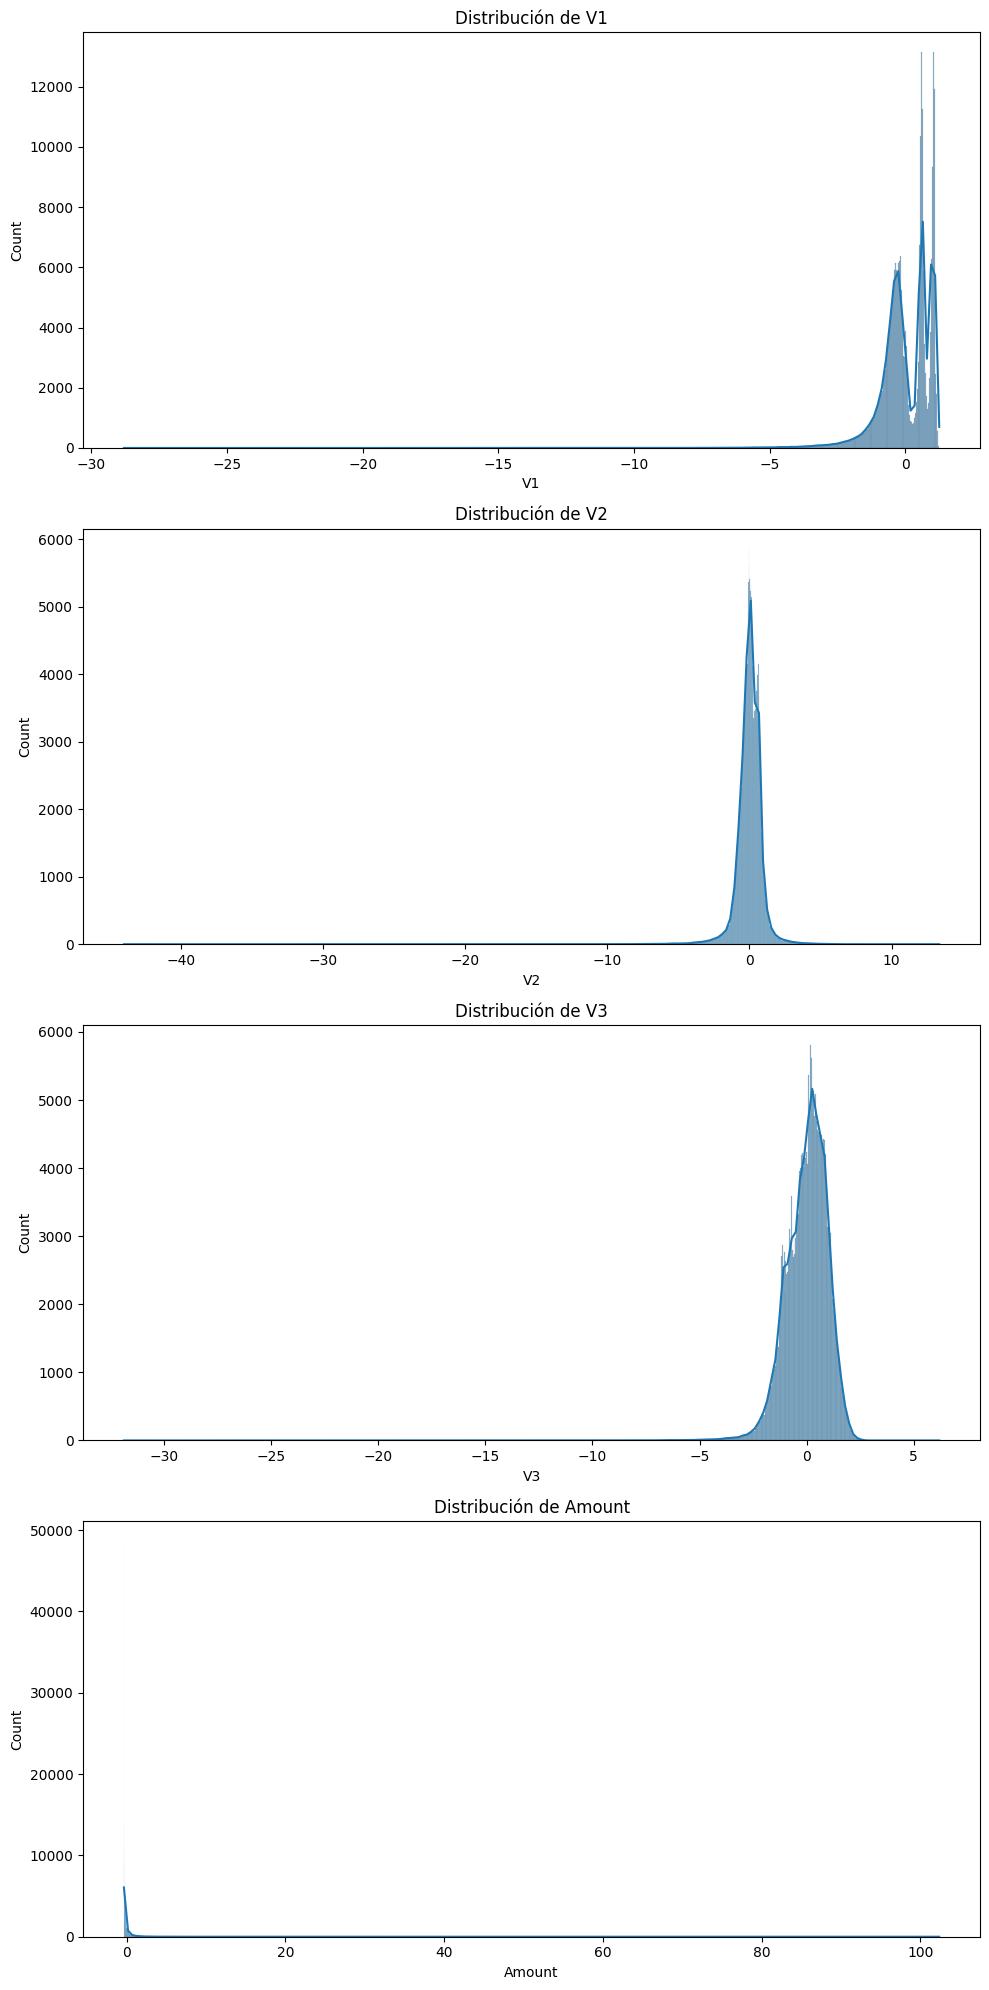

2024-10-25 17:14:54,364 - __main__ - INFO - Función plot_histograms completada
2024-10-25 17:14:54,365 - __main__ - INFO - Función plot_histograms ejecutada en 9.38 segundos


In [29]:
# Visualizar histogramas de las principales características
eda.plot_histograms(['V1', 'V2', 'V3', 'Amount'])

2024-10-25 17:15:02,170 - __main__ - INFO - Llamando a la función: plot_correlation_matrix


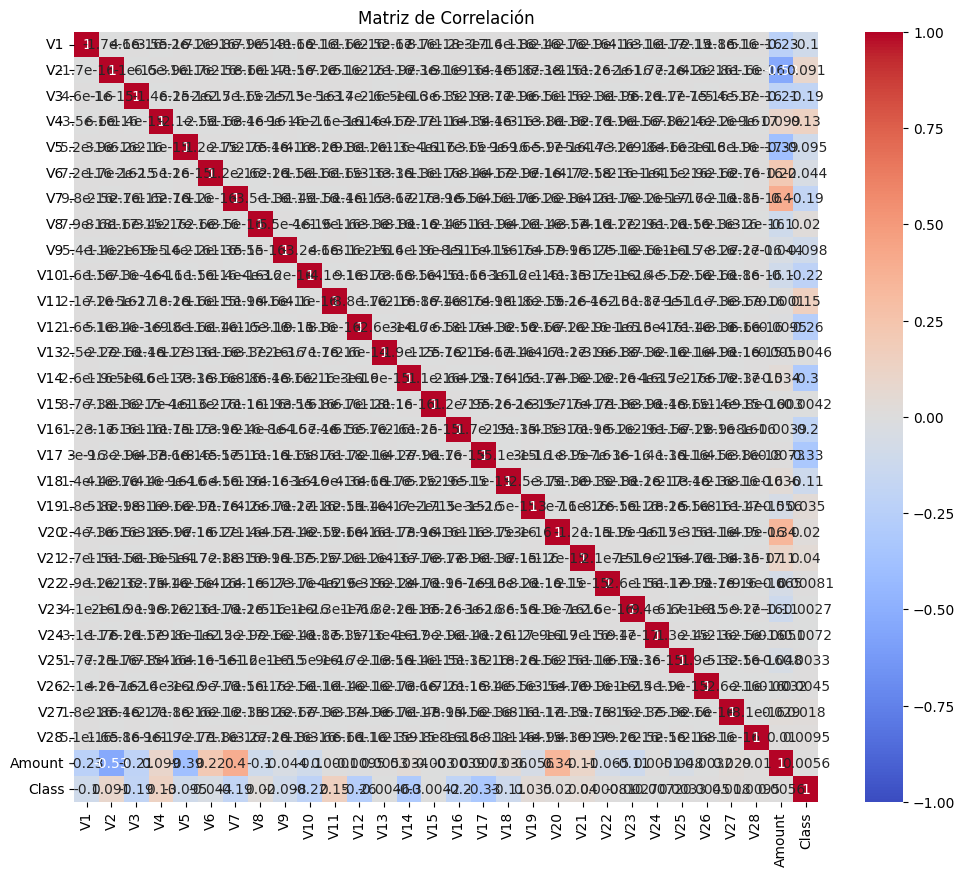

2024-10-25 17:15:03,615 - __main__ - INFO - Función plot_correlation_matrix completada
2024-10-25 17:15:03,615 - __main__ - INFO - Función plot_correlation_matrix ejecutada en 1.44 segundos


In [30]:
# Generar la matriz de correlación
eda.plot_correlation_matrix()

2024-10-25 17:15:06,706 - __main__ - INFO - Llamando a la función: plot_boxplots


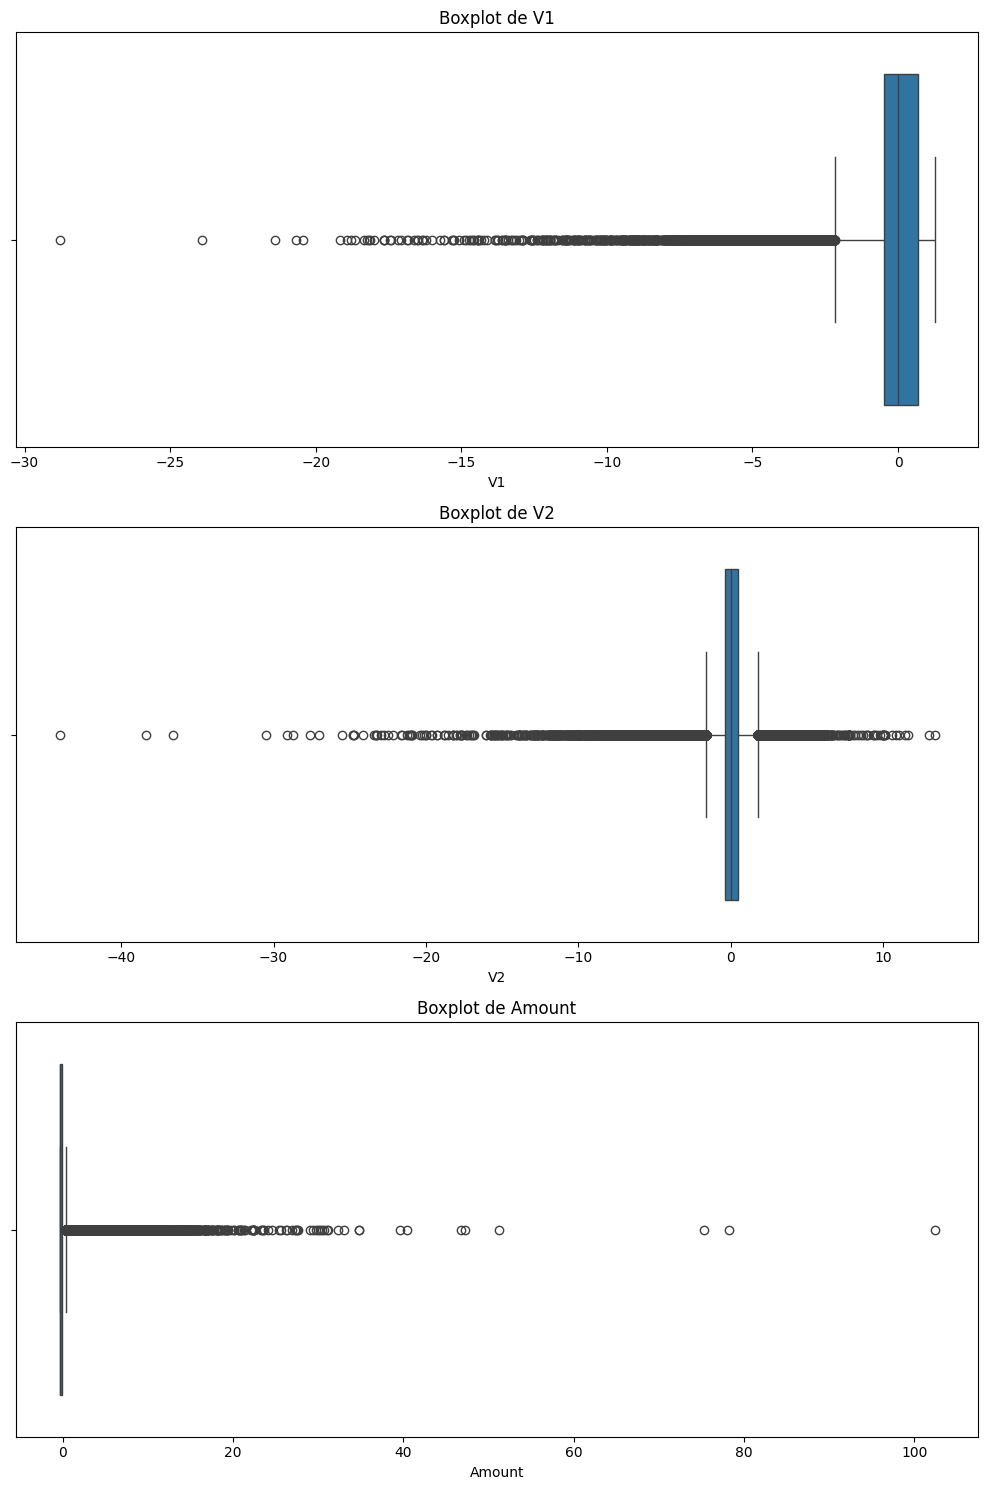

2024-10-25 17:15:08,296 - __main__ - INFO - Función plot_boxplots completada
2024-10-25 17:15:08,296 - __main__ - INFO - Función plot_boxplots ejecutada en 1.59 segundos


In [31]:
# Ver los boxplots de algunas variables
eda.plot_boxplots(['V1', 'V2', 'Amount'])

In [32]:
# Imprimir estadísticas resumen
eda.print_summary_statistics()

2024-10-25 17:15:12,329 - __main__ - INFO - Llamando a la función: print_summary_statistics
2024-10-25 17:15:12,583 - __main__ - INFO - Función print_summary_statistics completada
2024-10-25 17:15:12,584 - __main__ - INFO - Función print_summary_statistics ejecutada en 0.26 segundos


                 V1            V2            V3            V4            V5  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean  -1.506872e-17 -9.580116e-18 -8.622104e-17 -5.189230e-18  3.832046e-17   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00  1.000002e+00   
min   -2.879855e+01 -4.403529e+01 -3.187173e+01 -4.013919e+00 -8.240810e+01   
25%   -4.698918e-01 -3.624707e-01 -5.872142e-01 -5.993788e-01 -5.010686e-01   
50%    9.245351e-03  3.965683e-02  1.186124e-01 -1.401724e-02 -3.936682e-02   
75%    6.716939e-01  4.867202e-01  6.774569e-01  5.250082e-01  4.433465e-01   
max    1.253351e+00  1.335775e+01  6.187993e+00  1.191874e+01  2.521413e+01   

                 V6            V7            V8            V9           V10  \
count  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05  2.848070e+05   
mean   9.979288e-18  1.237432e-17 -3.193372e-18  7.234983e-19  5.588401e-18   
std    1.000002e+00  1.000002e+00  1.000002e+00  1.

2024-10-25 17:15:13,874 - __main__ - INFO - Llamando a la función: plot_target_distribution
2024-10-25 17:15:14,007 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-10-25 17:15:14,078 - matplotlib.category - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


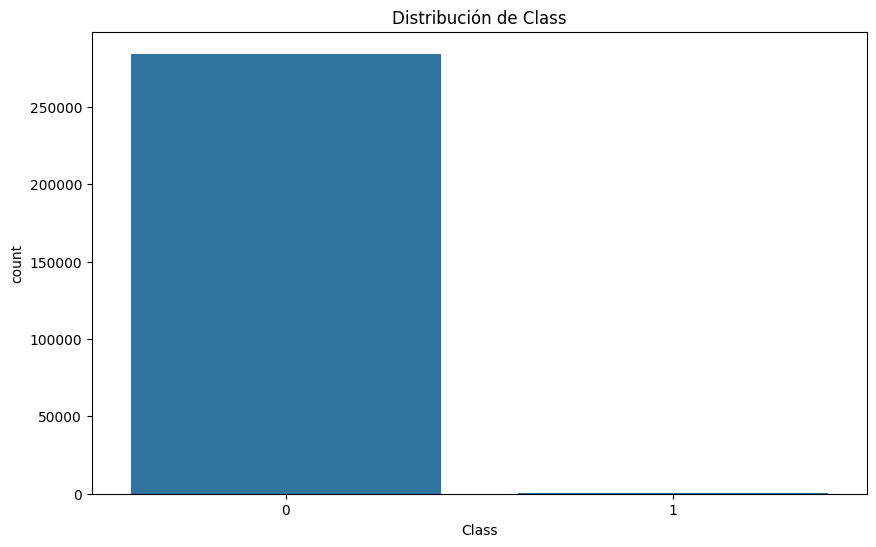

2024-10-25 17:15:14,176 - __main__ - INFO - Función plot_target_distribution completada
2024-10-25 17:15:14,176 - __main__ - INFO - Función plot_target_distribution ejecutada en 0.30 segundos


In [33]:
# Ver la distribución de la variable objetivo
eda.plot_target_distribution('Class')

In [34]:
class MixtureOfAgents(BaseEstimator, ClassifierMixin):
    def __init__(self, models=None, weights=None, experiment_name="MOA_Experiment", data_dir="../data"):
        self.models = models or []
        self.weights = weights
        self.classes_ = None
        self.experiment_name = experiment_name
        self.data_dir = data_dir
        mlflow.set_experiment(experiment_name)

    @timer_decorator
    @error_handler
    @log_decorator
    def add_model(self, model, weight=1.0):
        """Añade un modelo al conjunto."""
        self.models.append(model)
        if self.weights is None:
            self.weights = [1.0] * len(self.models)
        else:
            self.weights.append(weight)

    @timer_decorator
    @error_handler
    @log_decorator
    def split_and_save_data(self, X, y, test_size=0.2, val_size=0.2):
        """Divide los datos en conjuntos de entrenamiento, validación y prueba, y los guarda."""
        # Primera división: separar el conjunto de prueba
        X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=42)
        
        # Segunda división: separar el conjunto de validación del de entrenamiento
        val_size_adjusted = val_size / (1 - test_size)
        X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=val_size_adjusted, stratify=y_train_val, random_state=42)

        # Crear directorios si no existen
        for dir_name in ['train', 'val', 'test']:
            os.makedirs(os.path.join(self.data_dir, dir_name), exist_ok=True)

        # Guardar los conjuntos de datos
        pd.concat([X_train, y_train], axis=1).to_csv(os.path.join(self.data_dir, 'train', 'train_data.csv'), index=False)
        pd.concat([X_val, y_val], axis=1).to_csv(os.path.join(self.data_dir, 'val', 'val_data.csv'), index=False)
        pd.concat([X_test, y_test], axis=1).to_csv(os.path.join(self.data_dir, 'test', 'test_data.csv'), index=False)

        return X_train, X_val, X_test, y_train, y_val, y_test

    @timer_decorator
    @error_handler
    @log_decorator
    def load_data(self, data_type='train'):
        """Carga los datos del directorio especificado."""
        file_path = os.path.join(self.data_dir, data_type, f'{data_type}_data.csv')
        data = pd.read_csv(file_path)
        y = data.pop('target')  # Asumimos que la columna objetivo se llama 'target'
        X = data
        return X, y

    @timer_decorator
    @error_handler
    @log_decorator
    def fit(self, X, y):
        """Entrena todos los modelos en el conjunto."""
        X, y = check_X_y(X, y)
        self.classes_ = unique_labels(y)

        with mlflow.start_run(run_name="MOA_Training"):
            for i, model in enumerate(self.models):
                with mlflow.start_run(run_name=f"Model_{i}_Training", nested=True):
                    model.fit(X, y)
                    mlflow.log_param(f"model_{i}", type(model).__name__)
                    mlflow.log_param(f"weight_{i}", self.weights[i])

            mlflow.log_param("n_models", len(self.models))
            mlflow.sklearn.log_model(self, "moa_model")

        return self

    @timer_decorator
    @error_handler
    @log_decorator
    def predict_proba(self, X):
        """Predice las probabilidades de clase para X."""
        check_is_fitted(self)
        X = check_array(X)

        predictions = []
        for model, weight in zip(self.models, self.weights):
            if hasattr(model, "predict_proba"):
                pred = model.predict_proba(X)
            else:
                pred = np.eye(len(self.classes_))[model.predict(X)]
            predictions.append(weight * pred)

        return np.sum(predictions, axis=0) / np.sum(self.weights)

    @timer_decorator
    @error_handler
    @log_decorator
    def predict(self, X):
        """Predice las etiquetas de clase para X."""
        proba = self.predict_proba(X)
        return self.classes_[np.argmax(proba, axis=1)]

    @timer_decorator
    @error_handler
    @log_decorator
    def evaluate(self, X, y):
        """Evalúa el rendimiento del modelo."""
        y_pred = self.predict(X)
        metrics = {
            'accuracy': accuracy_score(y, y_pred),
            'precision': precision_score(y, y_pred, average='weighted'),
            'recall': recall_score(y, y_pred, average='weighted'),
            'f1': f1_score(y, y_pred, average='weighted')
        }

        with mlflow.start_run(run_name="MOA_Evaluation"):
            for metric_name, metric_value in metrics.items():
                mlflow.log_metric(metric_name, metric_value)

        return metrics

In [35]:
moa = MixtureOfAgents(experiment_name="CreditCardFraudDetection")

In [36]:
moa.add_model(LogisticRegression(), weight=1.0)
moa.add_model(DecisionTreeClassifier(), weight=0.8)
moa.add_model(RandomForestClassifier(), weight=1.2)

2024-10-25 17:15:22,863 - __main__ - INFO - Llamando a la función: add_model
2024-10-25 17:15:22,864 - __main__ - INFO - Función add_model completada
2024-10-25 17:15:22,864 - __main__ - INFO - Función add_model ejecutada en 0.00 segundos
2024-10-25 17:15:22,865 - __main__ - INFO - Llamando a la función: add_model
2024-10-25 17:15:22,865 - __main__ - INFO - Función add_model completada
2024-10-25 17:15:22,865 - __main__ - INFO - Función add_model ejecutada en 0.00 segundos
2024-10-25 17:15:22,866 - __main__ - INFO - Llamando a la función: add_model
2024-10-25 17:15:22,866 - __main__ - INFO - Función add_model completada
2024-10-25 17:15:22,867 - __main__ - INFO - Función add_model ejecutada en 0.00 segundos


In [37]:
# Dividir los datos

X = prepared_data.drop('Class', axis=1)
y = prepared_data['Class']
X_train, X_val, X_test, y_train, y_val, y_test = moa.split_and_save_data(X, y)

2024-10-25 17:15:24,454 - __main__ - INFO - Llamando a la función: split_and_save_data
2024-10-25 17:15:31,273 - __main__ - INFO - Función split_and_save_data completada
2024-10-25 17:15:31,273 - __main__ - INFO - Función split_and_save_data ejecutada en 6.82 segundos


In [38]:
# Entrenar el modelo
moa.fit(X_train, y_train)

2024-10-25 17:15:36,758 - __main__ - INFO - Llamando a la función: fit
2024/10/25 17:17:25 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2024-10-25 17:17:25,417 - __main__ - INFO - Función fit completada
2024-10-25 17:17:25,418 - __main__ - INFO - Función fit ejecutada en 108.66 segundos


MixtureOfAgents(experiment_name='CreditCardFraudDetection',
                models=[LogisticRegression(), DecisionTreeClassifier(),
                        RandomForestClassifier()],
                weights=[1.0, 0.8, 1.2])

In [39]:
# Evaluar en el conjunto de validación
val_evaluation = moa.evaluate(X_val, y_val)
print("Evaluación en validación:", val_evaluation)

2024-10-25 17:17:29,379 - __main__ - INFO - Llamando a la función: evaluate
2024-10-25 17:17:29,380 - __main__ - INFO - Llamando a la función: predict
2024-10-25 17:17:29,380 - __main__ - INFO - Llamando a la función: predict_proba
2024-10-25 17:17:29,602 - __main__ - INFO - Función predict_proba completada
2024-10-25 17:17:29,602 - __main__ - INFO - Función predict_proba ejecutada en 0.22 segundos
2024-10-25 17:17:29,604 - __main__ - INFO - Función predict completada
2024-10-25 17:17:29,604 - __main__ - INFO - Función predict ejecutada en 0.22 segundos
2024-10-25 17:17:29,628 - __main__ - INFO - Función evaluate completada
2024-10-25 17:17:29,629 - __main__ - INFO - Función evaluate ejecutada en 0.25 segundos


Evaluación en validación: {'accuracy': 0.999385555282469, 'precision': np.float64(0.9993538839178945), 'recall': np.float64(0.999385555282469), 'f1': np.float64(0.9993452396069773)}


In [40]:
# Evaluar en el conjunto de prueba
test_evaluation = moa.evaluate(X_test, y_test)
print("Evaluación en prueba:", test_evaluation)

2024-10-25 17:17:33,705 - __main__ - INFO - Llamando a la función: evaluate
2024-10-25 17:17:33,706 - __main__ - INFO - Llamando a la función: predict
2024-10-25 17:17:33,706 - __main__ - INFO - Llamando a la función: predict_proba
2024-10-25 17:17:33,918 - __main__ - INFO - Función predict_proba completada
2024-10-25 17:17:33,919 - __main__ - INFO - Función predict_proba ejecutada en 0.21 segundos
2024-10-25 17:17:33,919 - __main__ - INFO - Función predict completada
2024-10-25 17:17:33,919 - __main__ - INFO - Función predict ejecutada en 0.21 segundos
2024-10-25 17:17:33,941 - __main__ - INFO - Función evaluate completada
2024-10-25 17:17:33,941 - __main__ - INFO - Función evaluate ejecutada en 0.24 segundos


Evaluación en prueba: {'accuracy': 0.9995084442259752, 'precision': np.float64(0.9994880000133358), 'recall': np.float64(0.9995084442259752), 'f1': np.float64(0.9994866318754644)}


In [44]:
# Guardar el modelo

mlflow.sklearn.save_model(moa, "../models/moa_model")

graph TD
    - A[Datos de Entrada] --> B{Mixture of Agents}
    - B --> |Distribuye datos| C[Modelo 1]
    - B --> |Distribuye datos| D[Modelo 2]
    - B --> |Distribuye datos| E[Modelo 3]
    - C --> |Predicción 1| F{Agregador}
    - D --> |Predicción 2| F
    - E --> |Predicción 3| F
    - F --> |Aplica pesos| G[Predicción Final]
    - H[Pesos de Modelos] --> F

Explicación del diagrama:

Datos de Entrada: El proceso comienza con los datos de entrada, que son las características de los clientes bancarios en nuestro caso. Mixture of Agents: Este es el núcleo de nuestro sistema. Recibe los datos de entrada y los distribuye a los diferentes modelos. Modelos Individuales (Modelo 1, Modelo 2, Modelo 3): Cada uno de estos representa un modelo de aprendizaje automático diferente (por ejemplo, Regresión Logística, Árbol de Decisión, Bosque Aleatorio). Cada modelo procesa los datos y genera su propia predicción. Predicciones Individuales: Cada modelo produce su propia predicción basada en los datos de entrada. Agregador: Este componente recibe las predicciones de todos los modelos individuales. Pesos de Modelos: Cada modelo tiene un peso asociado que determina su influencia en la predicción final. Estos pesos se aplican en el agregador. Predicción Final: El agregador combina las predicciones individuales, aplicando los pesos correspondientes, para producir una predicción final.

El proceso funciona de la siguiente manera:

Los datos de entrada se pasan al MOA. El MOA distribuye estos datos a cada uno de los modelos individuales. Cada modelo procesa los datos y genera su propia predicción. Estas predicciones individuales se envían al agregador. El agregador aplica los pesos a cada predicción. Se combinan las predicciones ponderadas para producir una predicción final.

La ventaja de este enfoque es que aprovecha las fortalezas de múltiples modelos. Algunos modelos pueden ser mejores en ciertos aspectos de la predicción, mientras que otros pueden capturar diferentes patrones en los datos. Al combinar sus predicciones, el MOA puede producir resultados más robustos y precisos que cualquier modelo individual. Además, al ajustar los pesos, puedes dar más importancia a los modelos que funcionan mejor para tu conjunto de datos específico, mejorando aún más el rendimiento general del sistema.

In [45]:
import pandas as pd
import mlflow
import mlflow.pyfunc
import joblib
import numpy as np


class Prediction:
    def __init__(self, model_path, data_prep_path):
        self.model = self.load_model(model_path)
        self.data_prep = self.load_data_prep(data_prep_path)
        self.expected_columns = ['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
                                 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19',
                                 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount']

    @staticmethod
    def load_model(model_path):
        """Carga el modelo desde el archivo."""
        return mlflow.pyfunc.load_model(model_path)

    @staticmethod
    def load_data_prep(data_prep_path):
        """Carga la instancia de preparación de datos."""
        return joblib.load(data_prep_path)

    def prepare_data(self, data):
        """Prepara los datos para la predicción."""
        # Crear una nueva instancia de la clase de preparación de datos
        data_prep_instance = self.data_prep.__class__(data)

        # Asegúrate de que las columnas esperadas están presentes antes de procesar
        missing_columns = [col for col in self.expected_columns if col not in data.columns]
        if missing_columns:
            raise KeyError(f"Faltan columnas en los datos: {missing_columns}")

        # Realizar la preparación de los datos
        prepared_data = data_prep_instance.prepare_data().get_prepared_data()

        return prepared_data[self.expected_columns]

    def predict(self, data):
        """Realiza predicciones usando el modelo."""
        prepared_data = self.prepare_data(data)
        return self.model.predict(prepared_data)

    def predict_proba(self, data):
        """Realiza predicciones de probabilidad usando el modelo."""
        prepared_data = self.prepare_data(data)
        proba = self.model.predict(prepared_data)
        # Asegurarse de que proba sea un array 2D
        if proba.ndim == 1:
            proba = np.column_stack((1 - proba, proba))
        return proba

    def predict_and_explain(self, data):
        """Realiza predicciones y proporciona explicaciones básicas."""
        predictions = self.predict(data)
        probabilities = self.predict_proba(data)

        results = []
        for i, pred in enumerate(predictions):
            explanation = f"Predicción: {'Fraudulenta' if pred == 1 else 'No Fraudulenta'}"
            explanation += f"\nProbabilidad de Fraude: {probabilities[i][1]:.2f}"
            explanation += f"\nProbabilidad de No Fraude: {probabilities[i][0]:.2f}"
            results.append(explanation)

        return results

In [46]:
# Crear una instancia de la clase Prediction
predictor = Prediction("../models/moa_model", "../models/data_preparation.pkl")

In [47]:
# Supongamos que tenemos un nuevo cliente con las siguientes características:
new_customer = {
    'V1': -1.359807, 'V2': -0.072781, 'V3': 2.536347, 'V4': 1.378155, 'V5': -0.338321,
    'V6': 0.462388, 'V7': 0.239599, 'V8': 0.098698, 'V9': 0.363787, 'V10': 0.090794,
    'V11': -0.551600, 'V12': -0.617801, 'V13': -0.991390, 'V14': -0.311169, 'V15': 1.468177,
    'V16': -0.470401, 'V17': 0.207971, 'V18': 0.025791, 'V19': 0.403993, 'V20': 0.251412,
    'V21': -0.018307, 'V22': 0.277838, 'V23': -0.110474, 'V24': 0.066928, 'V25': 0.128539,
    'V26': -0.189115, 'V27': 0.133558, 'V28': -0.021053, 'Amount': 149.62
}

# Convertir el diccionario en un DataFrame para pasar a la función
new_customer_df = pd.DataFrame([new_customer])

In [48]:
# Realizar la predicción del cliente
predicted_class = predictor.predict(new_customer_df)
print(f"Clase predicha: {'Fraudulenta' if predicted_class[0] == 1 else 'No Fraudulenta'}")

2024-10-25 17:19:25,957 - __main__ - INFO - Llamando a la función: prepare_data
2024-10-25 17:19:25,957 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-10-25 17:19:25,958 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-10-25 17:19:25,959 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.00 segundos
2024-10-25 17:19:25,959 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-10-25 17:19:25,965 - __main__ - INFO - Función handle_missing_values completada
2024-10-25 17:19:25,966 - __main__ - INFO - Función handle_missing_values ejecutada en 0.01 segundos
2024-10-25 17:19:25,966 - __main__ - INFO - Llamando a la función: normalize_numeric_features
2024-10-25 17:19:25,969 - __main__ - INFO - Función normalize_numeric_features completada
2024-10-25 17:19:25,970 - __main__ - INFO - Función normalize_numeric_features ejecutada en 0.00 segundos
2024-10-25 17:19:25,970 - __main__ - INFO - Función prepare_data com

Clase predicha: No Fraudulenta


In [49]:
# Realizar la predicción de las probabilidades
predicted_probabilities = predictor.predict_proba(new_customer_df)
print(f"Probabilidad de Fraude: {predicted_probabilities[0][1]:.2f}")
print(f"Probabilidad de No Fraude: {predicted_probabilities[0][0]:.2f}")

2024-10-25 17:19:29,322 - __main__ - INFO - Llamando a la función: prepare_data
2024-10-25 17:19:29,323 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-10-25 17:19:29,323 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-10-25 17:19:29,324 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.00 segundos
2024-10-25 17:19:29,324 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-10-25 17:19:29,328 - __main__ - INFO - Función handle_missing_values completada
2024-10-25 17:19:29,329 - __main__ - INFO - Función handle_missing_values ejecutada en 0.00 segundos
2024-10-25 17:19:29,329 - __main__ - INFO - Llamando a la función: normalize_numeric_features
2024-10-25 17:19:29,332 - __main__ - INFO - Función normalize_numeric_features completada
2024-10-25 17:19:29,333 - __main__ - INFO - Función normalize_numeric_features ejecutada en 0.00 segundos
2024-10-25 17:19:29,333 - __main__ - INFO - Función prepare_data com

Probabilidad de Fraude: 0.00
Probabilidad de No Fraude: 1.00


In [50]:
import os
from together import Together
from dotenv import load_dotenv

# Clase de integración con Together AI
class TogetherAIIntegration:
    def __init__(self):
        load_dotenv()
        self.client = Together(api_key=os.getenv("TOGETHER_API_KEY"))
        self.models = {
            "feature_generation": "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo",  # Cambiar a tu modelo
            "result_interpretation": "meta-llama/Meta-Llama-3.1-8B-Instruct-Turbo"
        }

    def generate_features(self, data):
        """Genera nuevas características usando LLM."""
        prompt = f"Given the following customer data, suggest 3 new relevant features:\n{data.to_dict()}"
        response = self.client.chat.completions.create(
            model=self.models["feature_generation"],
            messages=[{"role": "user", "content": prompt}],
            max_tokens=200
        )
        return response.choices[0].message.content

    def interpret_results(self, prediction, probabilities, customer_data):
        """Interpreta los resultados de la predicción usando LLM."""
        prompt = f"""
        Given the following prediction and customer data, provide a detailed explanation:
        Prediction: {'Churn' if prediction == 1 else 'No Churn'}
        Churn Probability: {probabilities[1]:.2f}
        Customer Data: {customer_data.to_dict()}
        """
        response = self.client.chat.completions.create(
            model=self.models["result_interpretation"],
            messages=[{"role": "user", "content": prompt}],
            max_tokens=300
        )
        return response.choices[0].message.content

In [51]:
# Ejemplo de uso
together_ai = TogetherAIIntegration()

In [52]:
# Integración con la clase Prediction
class EnhancedPrediction(Prediction):
    def __init__(self, model_path, data_prep_path):
        super().__init__(model_path, data_prep_path)
        self.together_ai = TogetherAIIntegration()

    def predict_and_explain(self, data):
        predictions = self.predict(data)
        probabilities = self.predict_proba(data)
        
        results = []
        for i, pred in enumerate(predictions):
            basic_explanation = f"Predicción: {'Abandono' if pred == 1 else 'No Abandono'}"
            basic_explanation += f"\nProbabilidad de Abandono: {probabilities[i][1]:.2f}"
            basic_explanation += f"\nProbabilidad de No Abandono: {probabilities[i][0]:.2f}"
            
            # Generar explicación detallada con el modelo LLM
            detailed_explanation = self.together_ai.interpret_results(pred, probabilities[i], data.iloc[i])
            
            results.append(f"{basic_explanation}\n\nExplicación detallada:\n{detailed_explanation}")
        
        return results

In [53]:
# Crear una instancia del predictor mejorado
enhanced_predictor = EnhancedPrediction("../models/moa_model", "../models/data_preparation.pkl")

# Realizar la predicción y generar una explicación
explanation = enhanced_predictor.predict_and_explain(new_customer_df)[0]
print(explanation)

2024-10-25 17:20:30,865 - __main__ - INFO - Llamando a la función: prepare_data
2024-10-25 17:20:30,866 - __main__ - INFO - Llamando a la función: remove_irrelevant_columns
2024-10-25 17:20:30,866 - __main__ - INFO - Función remove_irrelevant_columns completada
2024-10-25 17:20:30,867 - __main__ - INFO - Función remove_irrelevant_columns ejecutada en 0.00 segundos
2024-10-25 17:20:30,867 - __main__ - INFO - Llamando a la función: handle_missing_values
2024-10-25 17:20:30,874 - __main__ - INFO - Función handle_missing_values completada
2024-10-25 17:20:30,876 - __main__ - INFO - Función handle_missing_values ejecutada en 0.01 segundos
2024-10-25 17:20:30,877 - __main__ - INFO - Llamando a la función: normalize_numeric_features
2024-10-25 17:20:30,881 - __main__ - INFO - Función normalize_numeric_features completada
2024-10-25 17:20:30,881 - __main__ - INFO - Función normalize_numeric_features ejecutada en 0.00 segundos
2024-10-25 17:20:30,882 - __main__ - INFO - Función prepare_data com

Predicción: No Abandono
Probabilidad de Abandono: 0.00
Probabilidad de No Abandono: 1.00

Explicación detallada:
**Prediction Explanation: No Churn**

Given the customer data, the prediction is that the customer will not churn, with a churn probability of 0.00. This means that the model has high confidence that the customer will continue to be a loyal customer.

**Feature Analysis:**

To understand why the model made this prediction, let's analyze the features that contribute to the prediction. The features are represented by the variables V1 to V28, and the Amount.

1. **V1: -1.359807**: This feature is negative, indicating that the customer has a lower value in this dimension compared to others. However, its impact on the prediction is not significant.
2. **V2: -0.072781**: This feature is also negative, but its impact is minimal.
3. **V3: 2.536347**: This feature is positive, indicating that the customer has a higher value in this dimension compared to others. This feature has a sig